In [1]:
import pandas as pd
from sklearn.datasets import fetch_openml

letters, y = fetch_openml("letter", version=1, return_X_y=True, parser="auto")

feature_names = letters.columns.tolist()
letters["group"] = y  # Add group labels (letters A-Z)

# Verify groups
print("Groups:", letters["group"].unique())  # ['A', 'B', ..., 'Z']
print("Samples per group:\n", letters["group"].value_counts())

Groups: ['Z', 'P', 'S', 'H', 'F', ..., 'T', 'C', 'G', 'B', 'J']
Length: 26
Categories (26, object): ['A', 'B', 'C', 'D', ..., 'W', 'X', 'Y', 'Z']
Samples per group:
 group
U    813
D    805
P    803
T    796
M    792
A    789
X    787
Y    786
N    783
Q    783
F    775
G    773
E    768
B    766
V    764
L    761
R    758
I    755
O    753
W    752
S    748
J    747
K    739
C    736
H    734
Z    734
Name: count, dtype: int64


In [2]:
letters

,x-box,y-box,width,high,onpix,x-bar,y-bar,x2bar,y2bar,xybar,x2ybr,xy2br,x-ege,xegvy,y-ege,yegvx,group
0,2,4,4,3,2,7,8,2,9,11,7,7,1,8,5,6,Z
1,4,7,5,5,5,5,9,6,4,8,7,9,2,9,7,10,P
2,7,10,8,7,4,8,8,5,10,11,2,8,2,5,5,10,S
3,4,9,5,7,4,7,7,13,1,7,6,8,3,8,0,8,H
4,6,7,8,5,4,7,6,3,7,10,7,9,3,8,3,7,H
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,5,10,5,8,3,4,10,7,8,12,10,9,2,9,2,6,C
19996,4,7,6,5,3,7,8,2,10,12,6,8,1,9,6,8,Z
19997,4,8,4,6,4,7,8,7,4,10,7,6,3,9,3,7,O
19998,4,11,4,8,3,0,2,4,6,1,0,7,0,8,0,8,L


In [3]:
grouped_data = []
for letter in sorted(letters["group"].unique()):  # A, B, ..., Z
    mask = letters["group"] == letter
    samples = letters[mask].drop("group", axis=1).values # Remove class column
    grouped_data.append(samples)

# Structure: grouped_data[0] = all "A" samples, grouped_data[1] = "B", etc.
print(f"Number of groups (letters): {len(grouped_data)}")  # 26
print(f"Samples per group (e.g., 'A'): {len(grouped_data[0])}")  # ~789-813
print(f"Features per sample: {len(grouped_data[0][0])}")  # 16

Number of groups (letters): 26
Samples per group (e.g., 'A'): 789
Features per sample: 16


In [4]:
datasets = grouped_data

In [5]:
from src.ocsmm.OneClassSMMClassifier import OneClassSMMClassifier
classifier = OneClassSMMClassifier(nu=0.23)
classifier.fit(datasets)

Best gamma found.

kappa matrix calculated.

Found the alphas.



In [6]:
decision, y_pred = classifier.predict(datasets)

Calculating kappa...

calculatin rho
[2.88727293 2.88727372 2.88727377 2.88727344 2.88727372 2.88727365
 2.88727362 2.88727361 2.88727371 2.88727358]


In [7]:
decision

array([-6.48226382e-07,  3.50774761e-01,  1.47464966e-07,  4.93298095e-01,
        3.76569963e-01,  8.90188184e-02,  4.92613236e-01,  7.04217765e-01,
        1.58127177e-01,  1.90089675e-07,  6.58279591e-01, -1.33916104e-07,
        1.48786879e-07,  4.89777261e-01,  5.53253512e-01,  7.62419892e-08,
        3.42774161e-01,  4.38156678e-01,  4.07650496e-01,  4.30820264e-08,
        2.44377300e-01,  3.81183995e-08,  1.30706509e-07,  7.53082668e-01,
        5.41688432e-02,  7.65204389e-09])

In [8]:
y_pred

array([-1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [9]:
outlier_indices = [i for i, value in enumerate(y_pred) if value == -1]
outlier_indices

[0, 11]

In [10]:
from src.explanation_algorithms.OCSMMSHAP import OCSMMSHAP
# ocsmm_shap = OCSMMSHAP(X=datasets, classifier=classifier, decision=decision)
# ocsmm_shap.fit_ocsmmshap(X=datasets, num_coalitions=2**len(feature_names))

In [ ]:
# shapley_values = ocsmm_shap.return_deterministic_shapley_values()

In [11]:
import numpy as np
# np.save("shapley_values_letter_before.npy", shapley_values)

In [12]:
shapley_values = np.load("shapley_values_letter_before.npy")

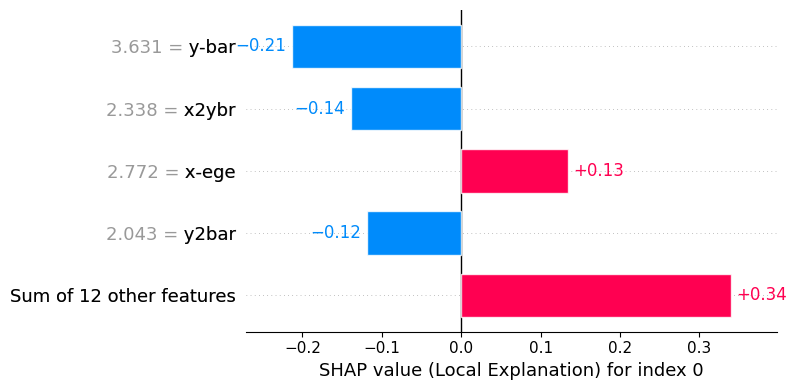

In [15]:
from src.utils.visualisation.deterministic_values import local_explanation_bar_plot, global_explanation_bar_plot
local_explanation_bar_plot(shapley_values.T, 0, feature_names=feature_names, datasets=datasets)

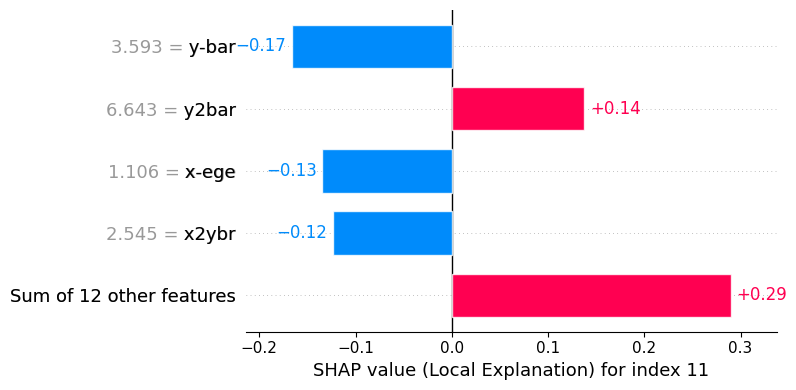

In [16]:
local_explanation_bar_plot(shapley_values.T, 11, feature_names=feature_names, datasets=datasets)

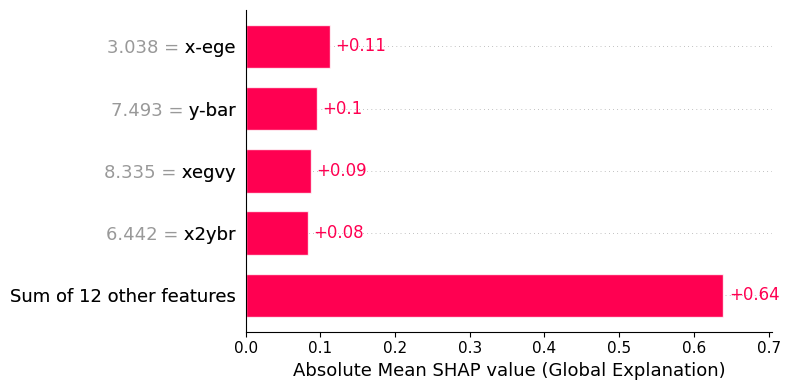

In [17]:
# global importance measure
mean_abs_shap_values = np.abs(shapley_values.T).mean(axis=0)  

# Call bar_plot for global explanation
global_explanation_bar_plot(mean_abs_shap_values, feature_names=feature_names, datasets=datasets)

In [20]:
q_group_idx = 16  # A=0, B=1, ..., Q=16, ..., Z=25
for sample in grouped_data[q_group_idx]:
    sample[0] += 5  # Perturb x-box (feature index 0)
    sample[3] *= 2  # Perturb high(feature index 3)

In [21]:
grouped_data

[array([[ 3, 11,  5, ...,  6,  4,  9],
        [ 4, 10,  6, ...,  7,  3,  8],
        [ 3,  5,  5, ...,  6,  3,  6],
        ...,
        [ 2,  7,  4, ...,  6,  2,  8],
        [ 2,  6,  3, ...,  6,  1,  8],
        [ 4, 11,  6, ...,  7,  1,  8]], shape=(789, 16)),
 array([[ 4,  8,  6, ..., 10,  8,  9],
        [ 3,  9,  4, ...,  8,  9, 10],
        [ 5,  9,  7, ...,  8,  4, 12],
        ...,
        [ 2,  4,  3, ...,  8,  5,  9],
        [ 3,  3,  4, ...,  8,  9, 10],
        [ 5,  8,  8, ...,  8,  6, 10]], shape=(766, 16)),
 array([[ 2,  3,  2, ...,  9,  2,  7],
        [ 7, 10,  5, ...,  8,  5,  9],
        [ 3,  4,  4, ..., 10,  3,  7],
        ...,
        [ 2,  3,  2, ...,  9,  3,  8],
        [ 3,  7,  4, ...,  8,  2,  6],
        [ 5, 10,  5, ...,  9,  2,  6]], shape=(736, 16)),
 array([[ 1,  0,  2, ...,  8,  3,  8],
        [ 3,  8,  5, ...,  8,  3,  7],
        [ 2,  5,  4, ...,  8,  3,  8],
        ...,
        [ 9, 15,  9, ...,  7,  6, 10],
        [ 2,  1,  3, ...,  8,  3,

In [22]:
classifier = OneClassSMMClassifier(nu=0.2)

In [23]:
classifier.fit(datasets)

Best gamma found.

kappa matrix calculated.

Found the alphas.



In [24]:
decision, y_pred = classifier.predict(datasets)

Calculating kappa...

calculatin rho
[2.096768   2.09676779 2.09676784 2.09676796 2.09676796 2.09676759
 1.26309899 2.0967675  2.09676761 2.09676786 2.0967677 ]


In [25]:
decision

array([ 0.0757883 ,  0.33657421,  0.07578808,  0.43603491,  0.34321781,
        0.13088905,  0.44892091,  0.59467144,  0.18696112,  0.07578813,
        0.55661942,  0.07578825,  0.07578825,  0.43792605,  0.49482778,
        0.07578788, -0.75788072,  0.40408184,  0.37759059,  0.07578779,
        0.25907503,  0.0757879 ,  0.07578815,  0.62568171,  0.12902759,
        0.07578799])

In [26]:
y_pred

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [27]:
outlier_indices = [i for i, value in enumerate(y_pred) if value == -1]
outlier_indices

[16]

In [28]:
# ocsmm_shap = OCSMMSHAP(X=datasets, classifier=classifier, decision=decision)
# ocsmm_shap.fit_ocsmmshap(X=datasets, num_coalitions=2**len(feature_names))

In [29]:
# wait!!!! - run prev
# shapley_values = ocsmm_shap.return_deterministic_shapley_values()

In [30]:
import numpy as np
# np.save("shapley_values_letter_after.npy", shapley_values)

In [31]:
shapley_values = np.load("shapley_values_letter_after.npy")

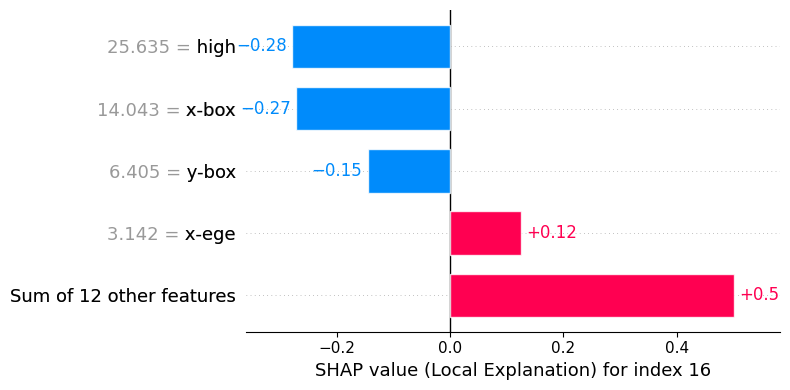

In [33]:
local_explanation_bar_plot(shapley_values.T, 16, feature_names=feature_names, datasets=datasets)

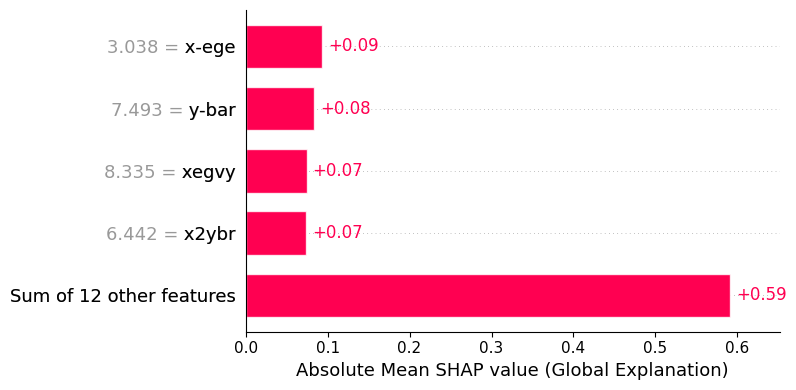

In [34]:
# global importance measure
mean_abs_shap_values = np.abs(shapley_values.T).mean(axis=0)  

# Call bar_plot for global explanation
global_explanation_bar_plot(mean_abs_shap_values, feature_names=feature_names, datasets=datasets)